# 4IF Data Mining Lab
Nadine Saadalla, Noémie Varjabedian, Eléonore Dravet  
February 2025


# Introduction
During this Data Mining project, we will be analyzing the geolocation data of photographs taken in the Grand Lyon. The data comes from the Flickr database and was taken between 2010 and 2019. We will explore different clustering methods to identify areas of interest for tourism in the metropolis, i.e. areas where many photographs are taken. Finally, we'll work on photograph captions to assign descriptions to our areas of interest

# Python set-up

In this section, we will set up a virtual python environment and install all necessary packages to run the code.

In [98]:
! source ./vitualenvpython/bin/activate
! which python3

/bin/bash: ligne 1: ./vitualenvpython/bin/activate: Aucun fichier ou dossier de ce nom
/home/nsaadalla/.local/share/r-miniconda/bin/python3


In [ ]:
# installation of required libraries and dependencies
# numeric calculations
! pip install numpy==1.26.0 
# data frames 
! pip install pandas==2.1.1 
# machine learning algorithms 
! pip install scikit-learn==1.5.1 
! pip install scipy==1.12.0
# plotting 
! pip install plotly==5.24.1 
! pip install matplotlib==3.8.0 
! pip install plotly-express==0.4.1 
! pip install chart-studio==1.1.0 
# web app library 
! pip install streamlit==1.37.1 
#maping library
! pip install folium
# association rules
! pip install mlxtend==0.23.3

! pip install nbformat==5.9.2 
! pip install pandas wordcloud deep_translator nltk
! pip install yellowbrick



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
ERROR: Operation cancelled by user
^C

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
# load pandas to deal with the data
import pandas as pd
# plotting
import matplotlib.pyplot as plt
import folium
import numpy as np
#Kmeans
from sklearn.cluster import KMeans
#silhouette score
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer
#Map
import folium
#clustering groups
from scipy.spatial import ConvexHull, QhullError
#Hierarchical
from sklearn.cluster import AgglomerativeClustering
#DBSCAN
from sklearn.cluster import DBSCAN
#Tags
from collections import Counter
#Images
import os
#Wordcloud
import nltk
import time
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from deep_translator import GoogleTranslator

# Data loading and cleaning

We start by viewing the current dataset.

In [ ]:
data = pd.read_table("flickr_data2.csv", sep=",")
data.head()

### Cleaning data in unnamed columns

In [ ]:
data.info()

We notice the three lines    

16  Unnamed: 16          142 non-null     float64  
17  Unnamed: 17          0 non-null       float64  
18  Unnamed: 18          2 non-null       float64  

which indicate that some lines have values in unnamed columns, probably due to a wrong use of the separators ','. They represent a very small ration of the overall data (~150/420 000) so we chose to delete those lines without further investigation. 

In [ ]:
unnamed_columns = data.columns[data.columns.str.contains('^Unnamed')]
data = data.loc[~data["Unnamed: 16"].notna(),:]
data = data.loc[~data["Unnamed: 17"].notna(),:]
data = data.loc[~data["Unnamed: 18"].notna(),:]
data.info()

The lines have been deleted ("0 non-null"). The columns still appear, we can delete them. 

In [ ]:
data=data.drop(columns=unnamed_columns)
data.info()

### Spaces

We notice that except for 'id', the column names start with a space. To manipulate the columns more easily, we remove these spaces. 

In [ ]:
data=data.rename(columns=lambda x: x.strip())

### Incoherent values
We can look at the statistics to check that they are coherent.

In [ ]:
data.describe()

We see that the max date_taken_year is 2238, which is impossible. This pushes us to delete all rows where the date taken is more than 2025 (the current year), and print all the years where pictures have been taken in our dataset, to check that everything is coherent.


In [ ]:
index=data[data['date_taken_year']>2025].index
data.drop(index=index,axis=1)
taken_years = data["date_taken_year"].unique()
uploded_years = data["date_upload_year"].unique()
print(f" When pictures are taken : {taken_years}\n")
print(f" When pictures are uploaded : {uploded_years}")

<a id="missing-vals"></a>
### Missing Values

In [ ]:
data.isna().sum()

We see that the missing values are either from the tags, the title or the upload_year. For our analysis on the coordinates, these information are not determining and we can choose to keep the corresponding data. However, in order to run our algorithm, we sample the data (our CPUs are not powerful enough to run with all the data) and keep only a thousand points, so we may as well keep the data with tags for our text analysis later.

In [ ]:
data=data.drop(index=data[data['tags'].isna()].index)

<a id="duplicates"></a>
### Duplicates

For our analysis to be pertinent, we do not want to count several times pictures taken by the same person, in the same place, in the same hour. This allows us to count visits. This avoids getting influenced by someone taking burst photos as well. Hence we remove the duplicates using the following columns. 

In [ ]:
columns_for_duplicates=['user', 'lat', 'long','date_taken_hour', 'date_taken_day', 'date_taken_month','date_taken_year', 'date_upload_minute', 'date_upload_hour','date_upload_day', 'date_upload_month', 'date_upload_year']
data=data.drop_duplicates(subset=columns_for_duplicates)

We now have ~90 00 points from the ~420 000 initial. We still have enough values. 

In [ ]:
data.info()

We can visualize all the points on a map as a last check of our values. We choose 1000 random tagged points.

In [ ]:
m = folium.Map([45.762611,4.832805	], zoom_start=14)
data_sample = data.sample(1000)

for index, row in data_sample.iterrows():
    folium.Marker(
        location=[row["lat"],row["long"]],
        icon=folium.DivIcon(html=f"""<svg width="20px" height="20px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
        <path d="M12 9.5C13.3807 9.5 14.5 10.6193 14.5 12C14.5 13.3807 13.3807 14.5 12 14.5C10.6193 14.5 9.5 13.3807 9.5 12C9.5 10.6193 10.6193 9.5 12 9.5Z" fill="#e63946"/>
        </svg>""")
    ).add_to(m)

m

Everything looks cleaned. We can save our cleaned data to a new csv and work with this version as for now. We will not have do do the treatment again since we can just directly use the data_cleaned.csv. 

In [ ]:
data.to_csv('./data_cleaned.csv',index=False)

# Analyzing clustering methods

In [ ]:

data_cleaned=pd.read_csv('./data_cleaned.csv')
data_sample = data_cleaned.sample(1000, random_state=42)
cluster_colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#FFA500', '#800080']

## k-means Clustering and Find the Optimal Number of Clusters using Elbow Method

Before using the Elbow method, we observe the different clusters we obtain by changing the value of k. 

### Elbow method 
We use the elbow method to determine the best parameter k for our K-Means clustering.

In [ ]:
inertias = []
for i in range(1,30):
  kmeans=KMeans(n_clusters=i,init='k-means++')
  kmeans.fit(data_sample[["lat", "long"]])
  inertias.append(kmeans.inertia_)

plt.plot(range(1,30),inertias)
plt.show()

The optimal value seems to be k=7. When we visualize the result on the map, there are not enough clusters to represent touristic places. We hence chose to use a higher k to adapt to the reality.

P.S. : We only show clusters than contain more than 10 points. Samller clusters are considered irrelevant. This changes nothing for k=7 but for a bigger k or for other methods, this rule has an impact on the printed map.

### k-means = 7 | 100 maps

In [ ]:
k = 7

kmeans = KMeans(n_clusters=k, init='k-means++')
kmeans.fit(data_sample[["lat", "long"]])

m = folium.Map(location=[45.762611, 4.832805], zoom_start=14)

labels = kmeans.labels_

clustered_points = data_sample.assign(cluster=labels)

for cluster_id in clustered_points['cluster'].unique():
    cluster_points = clustered_points[clustered_points['cluster'] == cluster_id]
    points = cluster_points[['lat', 'long']].values

    if len(points) >= 10:  # We only show clusters with more than 10 points.
        try:
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]  
            
            folium.Polygon(
                locations=hull_points,
                color=cluster_colors[cluster_id % len(cluster_colors)],
                weight=2,
                fill=True,
                fill_opacity=0.2
            ).add_to(m)
        except QhullError:
            print(f"Cluster {cluster_id}: QhullError occurred; skipping hull computation.")
    else:
        print(f"Cluster {cluster_id}: Less than 10 points; skipping perimeter.")

for _, row in data_sample.iterrows():
    folium.Marker(
        location=[row["lat"], row["long"]],
        icon=folium.DivIcon(html=f"""
        <svg width="10px" height="10px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
            <circle cx="12" cy="12" r="5" fill="black"/>
        </svg>
        """)
    ).add_to(m)

m.save("cluster_map_k_means_7.html")
m


In [ ]:
k = 100

kmeans = KMeans(n_clusters=k, init='k-means++')
kmeans.fit(data_sample[["lat", "long"]])

m = folium.Map(location=[45.762611, 4.832805], zoom_start=14)

labels = kmeans.labels_

clustered_points = data_sample.assign(cluster=labels)

for cluster_id in clustered_points['cluster'].unique():
    cluster_points = clustered_points[clustered_points['cluster'] == cluster_id]
    points = cluster_points[['lat', 'long']].values

    if len(points) >= 10:  # We only show clusters with more than 10 points.
        try:
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]  
            
            
            folium.Polygon(
                locations=hull_points,
                color=cluster_colors[cluster_id % len(cluster_colors)],
                weight=2,
                fill=True,
                fill_opacity=0.2
            ).add_to(m)
        except QhullError:
            print(f"Cluster {cluster_id}: QhullError occurred; skipping hull computation.")
    else:
        print(f"Cluster {cluster_id}: Less than 10 points; skipping perimeter.")

for _, row in data_sample.iterrows():
    folium.Marker(
        location=[row["lat"], row["long"]],
        icon=folium.DivIcon(html=f"""
        <svg width="10px" height="10px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
            <circle cx="12" cy="12" r="5" fill="black"/>
        </svg>
        """)
    ).add_to(m)

m.save("cluster_map_k_means_100.html")
m


## Silhouette Coefficient

In [ ]:
kmeans=KMeans(n_clusters=100,init='k-means++')
data_sample['cluster kmeans']=labels
silhouette_df=data_sample.copy()

silhouette_df =silhouette_df.sort_values(by=["cluster kmeans"])

silhouette_df["silhouettes"] = silhouette_samples(silhouette_df[['lat','long']],silhouette_df["cluster kmeans"])

cluster_silhouette_score = silhouette_df[["cluster kmeans","silhouettes"]].groupby(["cluster kmeans"]).mean()["silhouettes"]
cluster_silhouette_score
cluster_silhouette_score.max() #or min()
average_silhouette_score = silhouette_df["silhouettes"].mean()
average_silhouette_score


0.5055402601058556

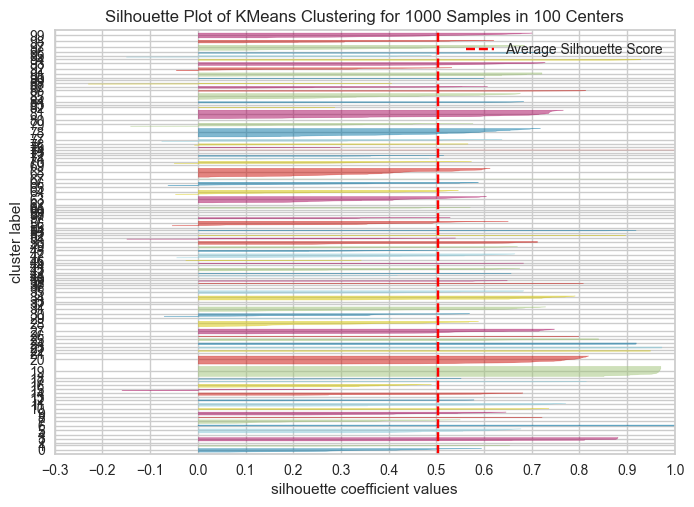

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 1000 Samples in 100 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [ ]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

# Fit the visualizer with the data
visualizer.fit(data_sample[['lat','long']])        # Fit the data to the visualizer

# Show the plot
visualizer.show()

The average scrore is 0.5 which is acceptable. By clusters, the scores are between 0 and 1 which is good. No cluster seems to be completely irrelevant. The cluster plot is not easily readable since there are 100 clusters but confirms that all seem relevant, except some lines that only contain probably one point.

## Hierarchical Clustering : single, complete and ward

In this part, we analyse the 3 variations of hierarchical clustering.

In [ ]:
clustering_single = AgglomerativeClustering(n_clusters=100, linkage='single').fit(data_sample[["lat", "long"]] )

In [ ]:
clustering_complete = AgglomerativeClustering(n_clusters=100, linkage='complete').fit(data_sample[["lat", "long"]] )

In [ ]:
clustering_ward = AgglomerativeClustering(n_clusters=100, linkage='ward').fit(data_sample[["lat", "long"]] )

After observing on the map the different results, we determine that the best hierarchical cluserting method is the ward one. 

To see the results on the map, we only need to change this line below with the corresponding clustering variation and then run the code. We left it at the ward method because we have concluded that it's the best of the three.

In [ ]:
labels = clustering_ward.labels_

In [ ]:
m = folium.Map(location=[45.762611, 4.832805], zoom_start=14)
clustered_points = data_sample.assign(cluster=labels)

for cluster_id in clustered_points['cluster'].unique():
    cluster_points = clustered_points[clustered_points['cluster'] == cluster_id]
    points = cluster_points[['lat', 'long']].values

    if len(points) >= 10: # We only show clusters with more than 10 points.
        try:
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]
            
            folium.Polygon(
                locations=hull_points,
                color=cluster_colors[cluster_id % len(cluster_colors)], 
                weight=2,
                fill=True,
                fill_opacity=0.2,
            ).add_to(m)
        except QhullError:
            print(f"Cluster {cluster_id}: QhullError occurred; skipping hull computation.")
    else:
        print(f"Cluster {cluster_id}: Less than 10 points; skipping perimeter.")

for _, row in data_sample.iterrows():
    folium.Marker(
        location=[row["lat"], row["long"]],
        icon=folium.DivIcon(html=f"""
        <svg width="10px" height="10px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
            <circle cx="12" cy="12" r="5" fill="black"/>
        </svg>
        """),

    ).add_to(m)

m.save("cluster_map_hierarchical.html")
m

## DBSCAN : 2 different settings

We try with random eps and min_samples and evaluate the result with the Silhouette coefficient. After adjusting, we find a satisfying score of 0.698 for eps = 0.03 and min_samples=5.

In [ ]:
clustering_db = DBSCAN(eps=0.03, min_samples=5).fit(data_sample[["lat", "long"]] )
DBlabels=clustering_db.labels_

silhouette_score(data_sample[["lat", "long"]], DBlabels)

In [ ]:
m = folium.Map(location=[45.762611, 4.832805], zoom_start=14)

labels = DBlabels

clustered_points = data_sample.assign(cluster=labels)

for cluster_id in clustered_points['cluster'].unique():
    if cluster_id < 0: #We remove outliers to not show them as a cluster
        print(f"Skipping cluster {cluster_id} (outlier)")
        continue
    cluster_points = clustered_points[clustered_points['cluster'] == cluster_id]
    points = cluster_points[['lat', 'long']].values

    if len(points) >= 3:  # We only show clusters with more than 3 points.
        try:
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]  
            
            
            folium.Polygon(
                locations=hull_points,
                color=cluster_colors[cluster_id % len(cluster_colors)],
                weight=2,
                fill=True,
                fill_opacity=0.2
            ).add_to(m)
        except QhullError:
            print(f"Cluster {cluster_id}: QhullError occurred; skipping hull computation.")
    else:
        print(f"Cluster {cluster_id}: Less than 3 points; skipping perimeter.")

for _, row in data_sample.iterrows():
    folium.Marker(
        location=[row["lat"], row["long"]],
        icon=folium.DivIcon(html=f"""
        <svg width="10px" height="10px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
            <circle cx="12" cy="12" r="5" fill="black"/>
        </svg>
        """)
    ).add_to(m)
m.save("cluster_map_dbscan.html")
m

When we visualize the clusters, we realize that one cluster is way too big. We can try other parameters that, even if they give a lower Silhouette score, might correspond better to the reality of touristic places of interest. We take a smaller eps to break down the big cluster in smaller ones. We can see that other clusters disappear (or have than 3 points, since we have chosen to only consider clusters with more than three photos taken). We then reduce min_samples to try to have more clusters elsewhere. The result is not as satisfying as other methods of clustering.

In [ ]:
clustering_db = DBSCAN(eps=0.001, min_samples=3).fit(data_sample[["lat", "long"]])
DBlabels=clustering_db.labels_

silhouette_score(data_sample[["lat", "long"]], DBlabels)

In [ ]:

m = folium.Map(location=[45.762611, 4.832805], zoom_start=14)

labels = DBlabels

clustered_points = data_sample.assign(cluster=labels)

for cluster_id in clustered_points['cluster'].unique():
    if cluster_id < 0: #We remove outliers to not show them as a cluster
        print(f"Skipping cluster {cluster_id} (outlier)")
        continue
    cluster_points = clustered_points[clustered_points['cluster'] == cluster_id]
    points = cluster_points[['lat', 'long']].values

    if len(points) >= 3:  # We only show clusters with more than 3 points.
        try:
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]  
            
            
            folium.Polygon(
                locations=hull_points,
                color=cluster_colors[cluster_id % len(cluster_colors)],
                weight=2,
                fill=True,
                fill_opacity=0.2
            ).add_to(m)
        except QhullError:
            print(f"Cluster {cluster_id}: QhullError occurred; skipping hull computation.")
    else:
        print(f"Cluster {cluster_id}: Less than 3 points; skipping perimeter.")

for _, row in data_sample.iterrows():
    folium.Marker(
        location=[row["lat"], row["long"]],
        icon=folium.DivIcon(html=f"""
        <svg width="10px" height="10px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
            <circle cx="12" cy="12" r="5" fill="black"/>
        </svg>
        """)
    ).add_to(m)
m.save("cluster_map_dbscan.html")
m

# Word Analysis

In order to attribute tags to each cluster, we need to first analyze and clean the existing word tags for each photo. 

We start by defining useful functions : 
- a function to tokenize the tags.
- a function to translate all tags to french (that way, all variations of the same word all regrouped).
- a function to generate the worldcloud for visual verification.

In [ ]:
nltk.download('stopwords')

# Function to tokenize the tags
def tokenize_tags(tags):
    all_words = sum([line.split(",") for line in tags], [])
    return all_words

# Function to translate words
def translate_word(word):
    try:
        trad = GoogleTranslator(source="auto", target="fr").translate(word)
        time.sleep(0.5)
        return trad
    except Exception as e:
        return word

# Function to generate the word cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(text))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()


Word cloud with all the words

In [ ]:
# word cloud
all_words = tokenize_tags(data_sample['tags'])

# Traduire tous les mots
# translated_words = [translate_word(word) for word in all_words[:20]] # fonctionne mais trop lent

print(all_words[:20])
# print(translated_words[:20])

generate_wordcloud(all_words, "Word Cloud Before Preprocessing")

### Processing

Word frequencies :

In [ ]:
def count_word_frequencies(word_list):

    word_freq = {}
    
    for word in word_list:
        if word in word_freq:
            word_freq[word] += 1
        else:
            word_freq[word] = 1
    
    return word_freq

word_freq = count_word_frequencies(all_words)

# In a dataframe for easier manipulation
word_ratio = pd.DataFrame(
        {"Word": word_freq.keys(), "Frequency": word_freq.values()}
    ).sort_values(by="Frequency", ascending=False)

print(word_ratio.head(50))

word_ratio.head(20).plot(kind="bar", x="Word", y="Frequency", legend=False)
plt.title("Top 20 Words by Frequency")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

Biggest cluster size

In [ ]:
labels = clustering_ward.labels_ 

# Count occurrences of each cluster
cluster_sizes = pd.Series(labels).value_counts().sort_values(ascending=False)
average_cluster_size = cluster_sizes.mean()

# Display cluster sizes
print(cluster_sizes)
print(average_cluster_size)

The biggest cluster has 55 points in it. So any word that comes more than 55 times may not be specific to any cluster so not relevant for the labelling. 

Words to eliminate

In [ ]:
import re

# Create a new list with only words that appear less than or equal to the threshold
filtered_words = [word for word in all_words if word_freq[word] < 25] # we did many tests and it seems like the best threshold

excluded_words = {"light","bw","nb","pentax","blackandwhite", "noiretblanc","lione", "frança","frankrijk","girl", "panorama", "europa", "monochrome", "photo", "rise", "urban", "street", "fr", "nikon", "canon","frankreich", "frankrig", "square", "squareformat", "thierryehrmann", "rhonealpes", "uploaded", "city", "ville", "night", "nuit"}
french_stopwords = set(stopwords.words('french'))

filtered_words = [
    word.lower() for word in filtered_words
    if word.lower() not in french_stopwords
    and word.lower() not in excluded_words
    and "square" not in word.lower()
    and re.match("^[a-zA-ZÀ-ÿ-]+$", word)  # Keep only words without symbols
]

# Print the filtered words count for verification
print(f"Original word count: {len(all_words)}")
print(f"Filtered word count: {len(filtered_words)}")

New word cloud with filtered words

In [ ]:

generate_wordcloud(filtered_words, "Word Cloud After Preprocessing")

And if we apply all that to the map : 

In [ ]:
m = folium.Map(location=[45.762611, 4.832805], zoom_start=15)

labels = clustering_ward.labels_

clustered_points = data_sample.assign(cluster=labels)

cluster_names = {}


for cluster_id in clustered_points['cluster'].unique():

    cluster_points = clustered_points[clustered_points['cluster'] == cluster_id]
    cluster_all_words = tokenize_tags(cluster_points['tags'])
    cluster_word_freq = count_word_frequencies(cluster_all_words)
    cluster_word_freq = {word: freq for word, freq in cluster_word_freq.items() if word in filtered_words}

    if cluster_word_freq:
        cluster_word_freq_sorted = pd.DataFrame(
            {"Word": cluster_word_freq.keys(), "Frequency": cluster_word_freq.values()}
        ).sort_values(by="Frequency", ascending=False)

        top_3 = cluster_word_freq_sorted.head(3)["Word"]

        cluster_name = ', '.join(top_3)
    else:
        cluster_name = f"Cluster {cluster_id}"
        
    cluster_names[cluster_id] = cluster_name

    points = cluster_points[['lat', 'long']].values  
    if len(points) >= 10: #We only show clusters with more than 10 points
        try:
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]
            
            folium.Polygon(
                locations=hull_points,
                color=cluster_colors[cluster_id % len(cluster_colors)],
                weight=2,
                fill=True,
                fill_opacity=0.2,
                tooltip=cluster_names[cluster_id]
            ).add_to(m)
        except QhullError:
            print(f"Cluster {cluster_id}: QhullError occurred; skipping hull computation.")
    else:
        print(f"Cluster {cluster_id}: Less than 10 points; skipping perimeter.")

for _, row in data_sample.iterrows():
    folium.Marker(
        location=[row["lat"], row["long"]],
        icon=folium.DivIcon(html=f"""
        <svg width="10px" height="10px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
            <circle cx="12" cy="12" r="5" fill="black"/>
        </svg>
        """),
        tooltip=row["tags"]
    ).add_to(m)

m.save("cluster_map_tags.html")
m


# Time analysis

We want to analyze the photos taken with respect to the hour of the day they were taken. This will help us analyse tourist flows, maybe organize toursit cars.

We want to cluster using the time in the day. The maximum precision we want is the minute. Hence we can create a new column using the hour and the minutes.

In [ ]:
data_sample_time = data_cleaned.sample(2000, random_state=42)
data_sample_time['time'] = data_sample_time['date_taken_hour']*60 + data_sample_time['date_taken_minute']
time = data_sample_time['time'].to_numpy()
distance = np.abs(time[:, None]-time) #create a matrix where distance[i,j] is the absolute difference between when picture i and picture j were taken
cluster_colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#FFA500', 'F0F000','F000F0','0F0F00','00F0F0','0F00F0','F0F0F0','F00F00','F00000','000000','FFFFFF']


## Using DBSCAN

In [ ]:
time_clustering_db = DBSCAN(eps=200, min_samples=10).fit(distance)
time_labels_dbscan=time_clustering_db.labels_
data_sample_time['time_cluster_dbscan']=time_labels_dbscan

In [ ]:
print(time_labels_dbscan)

In [ ]:
m = folium.Map(location=[45.762611, 4.832805], zoom_start=14)

labels = time_labels_dbscan

clustered_points = data_sample_time.assign(cluster=labels)

for _, row in clustered_points.iterrows():
    if cluster_id == -1: #We remove outliers to not show them as a cluster
        print(f"Skipping cluster {cluster_id} (outlier)")
        continue
    cluster_id = row['cluster']
    marker_color = cluster_colors[cluster_id % len(cluster_colors)]

    folium.Marker(
        location=[row["lat"], row["long"]],
        icon=folium.DivIcon(html=f"""
        <svg width="10px" height="10px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
            <circle cx="12" cy="12" r="5" fill="{marker_color}"/>
        </svg>
        """)
    ).add_to(m)
m.save("cluster_map_dbscan_time.html")
m

We do not notice a remarkable difference between the points belonging to the different clusters. We acn look at some statistics.

In [ ]:
data_sample_time[['time','time_cluster_dbscan']].groupby(by=['time_cluster_dbscan']).mean()/60

We can see that cluster means are mostly between 6am and 9am, around 3pm, and between 8pm and 12am.

In [ ]:
data_sample_time[['time','time_cluster_dbscan']].groupby(by=['time_cluster_dbscan']).count()

The biggest cluster is around 3pm. This cluster probably absorbed all photos taken in the day, times being densely distributed around.

In [ ]:
data_sample_time[['time','time_cluster_dbscan']].groupby(by=['time_cluster_dbscan']).min()/60

In [ ]:
data_sample_time[['time','time_cluster_dbscan']].groupby(by=['time_cluster_dbscan']).max()/60

Indeed, the big cluster ranges from 10am to 7pm. This clustering is not pertinent for our analysis since it is too big a range and we already have more than 10 clusters. We can try another clustering method such as K-means.

## Using K-means

In [ ]:
inertias = []
for i in range(1,30):
  kmeans=KMeans(n_clusters=i,init='k-means++')
  kmeans.fit(distance)
  inertias.append(kmeans.inertia_)

plt.plot(range(1,30),inertias)
plt.show()

The elbow is at around k=5.

In [ ]:
kmeans=KMeans(n_clusters=10,init='k-means++')
kmeans.fit(distance)
time_labels_kmeans=kmeans.labels_
data_sample_time['time_cluster_kmeans']=time_labels_kmeans

In [ ]:
m = folium.Map(location=[45.762611, 4.832805], zoom_start=12)

labels = time_labels_kmeans

clustered_points = data_sample_time.assign(cluster=labels)

for _, row in clustered_points.iterrows():
    cluster_id = row['cluster']
    marker_color = cluster_colors[cluster_id % len(cluster_colors)]

    folium.Marker(
        location=[row["lat"], row["long"]],
        icon=folium.DivIcon(html=f"""
        <svg width="10px" height="10px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
            <circle cx="12" cy="12" r="5" fill="{marker_color}"/>
        </svg>
        """)
    ).add_to(m)
m.save("cluster_map_time_kmeans.html")
m

In [ ]:
data_sample_time[['time','time_cluster_kmeans']].groupby(by=['time_cluster_kmeans']).mean()/60

We can see 4 clusters, with mean times more spread out in the day which is logical since using Kmeans.

In [ ]:
data_sample_time[['time','time_cluster_kmeans']].groupby(by=['time_cluster_kmeans']).count()

Clusters are also more equilibrated.

In [ ]:
data_sample_time[['time','time_cluster_kmeans']].groupby(by=['time_cluster_kmeans']).min()/60

In [ ]:
data_sample_time[['time','time_cluster_kmeans']].groupby(by=['time_cluster_kmeans']).max()/60

Results are coherent, most photos are taken between 4pm and 5pm. We can look at photos belonging to a specific cluster only on the map, for example cluster 7, between 5.30pm and 19.25pm.

In [ ]:
m = folium.Map(location=[45.762611, 4.832805], zoom_start=12)

labels = time_labels_kmeans

clustered_points = data_sample_time.assign(cluster=labels)

for _, row in clustered_points.iterrows():
    cluster_id = row['cluster']
    marker_color = cluster_colors[cluster_id % len(cluster_colors)]

    folium.Marker(
        location=[row["lat"], row["long"]],
        icon=folium.DivIcon(html=f"""
        <svg width="10px" height="10px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
            <circle cx="12" cy="12" r="5" fill="{marker_color}"/>
        </svg>
        """)
    ).add_to(m)
    
m.save("cluster_map_time_kmeans.html")
m


Unfortunately, we notice that photos are distributed similarly in all different time clusters throughout the day. This analysis will not be able to help the city of Lyon to better manage flows.

# Special function : show image on click

In order to show image taken when we click on a point, we had to first get a flicker key.

In [ ]:
FLICKR_API_KEY = "c9f9183c6f9f862b589a12aa27b9c8e6"

The process of showing images :
- We first wanted to show images on hover but the only way to do that was to preload all the images and that approximately 27 seconds to load 100 images and 5min30s to load all 1000.
- Thus we decided to show images on click instead however we faced the issue of dynamically rendering the photos when we click on the marker.
- We used HTML in order to dynamically render the images.

In [ ]:
unavailable_image_path = os.path.abspath("unavailable-image.jpg")

fetch_image_script = f"""
<script>
function fetchFlickrImage(photo_id, containerId) {{
    console.log("Fetching image for photo_id:", photo_id);
    var apiUrl = "https://api.flickr.com/services/rest/?method=flickr.photos.getInfo&api_key={FLICKR_API_KEY}&photo_id=" + photo_id + "&format=json&nojsoncallback=1";

    fetch(apiUrl)
        .then(response => response.json())
        .then(data => {{
            var container = document.getElementById(containerId);

            if (data.photo) {{
                var server_id = data.photo.server;
                var secret = data.photo.secret;
                var imageUrl = "https://live.staticflickr.com/" + server_id + "/" + photo_id + "_" + secret + ".jpg";
                console.log("Image URL:", imageUrl);

                // Replace placeholder with the fetched image
                container.innerHTML = "<img src='" + imageUrl + "' style='width: 250px; height: 180px; object-fit: cover; border-radius: 8px; display: block; margin: auto;'/>";
            }} else {{
                console.log("Image not found, using fallback.");
                container.innerHTML = "<img src='file://{unavailable_image_path}' style='width: 250px; height: 180px; object-fit: cover; border-radius: 8px; display: block; margin: auto;'/>";
            }}
        }})
        .catch(error => {{
            console.error("Error fetching image:", error);
            var container = document.getElementById(containerId);
            container.innerHTML = "<img src='file://{unavailable_image_path}' style='width: 250px; height: 180px; object-fit: cover; border-radius: 8px; display: block; margin: auto;'/>";
        }});
}}
</script>
"""

And in case you haven't run the code in order, make sure to run the next cell.

In [ ]:
clustering_ward = AgglomerativeClustering(n_clusters=100, linkage='ward').fit(data_sample[["lat", "long"]] )
labels = clustering_ward.labels_
cluster_colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#FFA500', '#800080']

In [ ]:
m = folium.Map(location=[45.762611, 4.832805], zoom_start=14)
clustered_points = data_sample.assign(cluster=labels)


m.get_root().html.add_child(folium.Element(fetch_image_script))

for cluster_id in clustered_points['cluster'].unique():
    cluster_points = clustered_points[clustered_points['cluster'] == cluster_id]
    points = cluster_points[['lat', 'long']].values

    if len(points) >= 10: # We only show clusters with more than 10 points.
        try:
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]
            
            folium.Polygon(
                locations=hull_points,
                color=cluster_colors[cluster_id % len(cluster_colors)], 
                weight=2,
                fill=True,
                fill_opacity=0.2,
            ).add_to(m)
        except QhullError:
            print(f"Cluster {cluster_id}: QhullError occurred; skipping hull computation.")
    else:
        print(f"Cluster {cluster_id}: Less than 10 points; skipping perimeter.")


for i, row in data_sample.iterrows():
    lat, lon, photo_id = row["lat"], row["long"], row["id"]
    
    
    link_id = f"image_link_{i}"
    container_id = f"image_container_{i}"

    popup_html = f"""
    <div id="{container_id}" style="width: 250px; height: 180px; display: flex; align-items: center; justify-content: center; text-align: center; border-radius: 8px; background-color: white; padding: 10px;">
        <a href="#" id="{link_id}" onclick="fetchFlickrImage('{photo_id}', '{link_id}', '{container_id}'); return false;"
           style="text-decoration: none; font-size: 14px; color: blue; font-weight: bold;">
            📷 Click to Load Image
        </a>
    </div>
    """

    popup = folium.Popup(popup_html, max_width=270)

    folium.Marker(
        location=[lat, lon],
        popup=popup,
        icon=folium.DivIcon(html=f"""
        <svg width="10px" height="10px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
            <circle cx="12" cy="12" r="5" fill="black"/>
        </svg>
        """),
    ).add_to(m)

m.save("cluster_map_click_images.html")
m


# All in one map : ward clustering, cluster tags, images and time clusters

In [ ]:
clustering_ward = AgglomerativeClustering(n_clusters=100, linkage='ward').fit(data_sample[["lat", "long"]] )
labels = clustering_ward.labels_

cluster_colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#FFA500', '#800080']


m = folium.Map(location=[45.762611, 4.832805], zoom_start=14)
clustered_points = data_sample.assign(cluster=labels)
cluster_names = {}
m.get_root().html.add_child(folium.Element(fetch_image_script))

for cluster_id in clustered_points['cluster'].unique():
    
    cluster_points = clustered_points[clustered_points['cluster'] == cluster_id]
    cluster_all_words = tokenize_tags(cluster_points['tags'])
    cluster_word_freq = count_word_frequencies(cluster_all_words)
    cluster_word_freq = {word: freq for word, freq in cluster_word_freq.items() if word in filtered_words}

    if cluster_word_freq:
        cluster_word_freq_sorted = pd.DataFrame(
            {"Word": cluster_word_freq.keys(), "Frequency": cluster_word_freq.values()}
        ).sort_values(by="Frequency", ascending=False)

        top_3 = cluster_word_freq_sorted.head(3)["Word"]

        cluster_name = ', '.join(top_3)
    else:
        cluster_name = f"Cluster {cluster_id}"
        
    cluster_names[cluster_id] = cluster_name

    points = cluster_points[['lat', 'long']].values

    if len(points) >= 10: # We only show clusters with more than 10 points.
        try:
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]
            
            folium.Polygon(
                locations=hull_points,
                color=cluster_colors[cluster_id % len(cluster_colors)], 
                weight=2,
                fill=True,
                fill_opacity=0.2,
                tooltip=cluster_names[cluster_id]
            ).add_to(m)
        except QhullError:
            print(f"Cluster {cluster_id}: QhullError occurred; skipping hull computation.")
    else:
        print(f"Cluster {cluster_id}: Less than 10 points; skipping perimeter.")


for i, row in data_sample.iterrows():
    lat, lon, photo_id = row["lat"], row["long"], row["id"]
    
    
    link_id = f"image_link_{i}"
    container_id = f"image_container_{i}"

    popup_html = f"""
    <div id="{container_id}" style="width: 250px; height: 180px; display: flex; align-items: center; justify-content: center; text-align: center; border-radius: 8px; background-color: white; padding: 10px;">
        <a href="#" id="{link_id}" onclick="fetchFlickrImage('{photo_id}', '{link_id}', '{container_id}'); return false;"
           style="text-decoration: none; font-size: 14px; color: blue; font-weight: bold;">
            📷 Click to Load Image
        </a>
    </div>
    """

    popup = folium.Popup(popup_html, max_width=270)

    folium.Marker(
        location=[lat, lon],
        popup=popup,
        icon=folium.DivIcon(html=f"""
        <svg width="10px" height="10px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
            <circle cx="12" cy="12" r="5" fill="black"/>
        </svg>
        """),
    ).add_to(m)

m.save("all_in_one_map.html")
m


Cluster 92: Less than 10 points; skipping perimeter.
Cluster 78: Less than 10 points; skipping perimeter.
Cluster 35: Less than 10 points; skipping perimeter.
Cluster 4: Less than 10 points; skipping perimeter.
Cluster 39: Less than 10 points; skipping perimeter.
Cluster 16: Less than 10 points; skipping perimeter.
Cluster 81: Less than 10 points; skipping perimeter.
Cluster 61: Less than 10 points; skipping perimeter.
Cluster 56: Less than 10 points; skipping perimeter.
Cluster 50: Less than 10 points; skipping perimeter.
Cluster 41: Less than 10 points; skipping perimeter.
Cluster 18: Less than 10 points; skipping perimeter.
Cluster 54: Less than 10 points; skipping perimeter.
Cluster 27: Less than 10 points; skipping perimeter.
Cluster 59: Less than 10 points; skipping perimeter.
Cluster 48: Less than 10 points; skipping perimeter.
Cluster 70: Less than 10 points; skipping perimeter.
Cluster 44: Less than 10 points; skipping perimeter.
Cluster 62: Less than 10 points; skipping perim

In [ ]:
clustering_ward = AgglomerativeClustering(n_clusters=100, linkage='ward').fit(data_sample[["lat", "long"]] )
labels = clustering_ward.labels_

cluster_colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#FFA500', '#800080']
point_colors = ['#FF0000', '#00FF00', '#0000FF', '#FFFF00', '#FF00FF', '#FFA500', 'F0F000','F000F0','0F0F00','00F0F0','0F00F0','F0F0F0','F00F00','F00000','000000','FFFFFF']

data_sample_time = data_cleaned.sample(2000, random_state=42)
data_sample_time['time'] = data_sample_time['date_taken_hour']*60 + data_sample_time['date_taken_minute']
time = data_sample_time['time'].to_numpy()
distance = np.abs(time[:, None]-time)
kmeans=KMeans(n_clusters=10,init='k-means++')
kmeans.fit(distance)
time_labels_kmeans=kmeans.labels_
data_sample_time['time_cluster_kmeans']=time_labels_kmeans
time_labels = time_labels_kmeans

m = folium.Map(location=[45.762611, 4.832805], zoom_start=14)
clustered_points = data_sample.assign(cluster=labels)
cluster_names = {}
m.get_root().html.add_child(folium.Element(fetch_image_script))

for cluster_id in clustered_points['cluster'].unique():
    
    cluster_points = clustered_points[clustered_points['cluster'] == cluster_id]
    cluster_all_words = tokenize_tags(cluster_points['tags'])
    cluster_word_freq = count_word_frequencies(cluster_all_words)
    cluster_word_freq = {word: freq for word, freq in cluster_word_freq.items() if word in filtered_words}

    if cluster_word_freq:
        cluster_word_freq_sorted = pd.DataFrame(
            {"Word": cluster_word_freq.keys(), "Frequency": cluster_word_freq.values()}
        ).sort_values(by="Frequency", ascending=False)

        top_3 = cluster_word_freq_sorted.head(3)["Word"]

        cluster_name = ', '.join(top_3)
    else:
        cluster_name = f"Cluster {cluster_id}"
        
    cluster_names[cluster_id] = cluster_name

    points = cluster_points[['lat', 'long']].values

    if len(points) >= 10: # We only show clusters with more than 10 points.
        try:
            hull = ConvexHull(points)
            hull_points = points[hull.vertices]
            
            folium.Polygon(
                locations=hull_points,
                color=cluster_colors[cluster_id % len(cluster_colors)], 
                weight=2,
                fill=True,
                fill_opacity=0.2,
                tooltip=cluster_names[cluster_id]
            ).add_to(m)
        except QhullError:
            print(f"Cluster {cluster_id}: QhullError occurred; skipping hull computation.")
    else:
        print(f"Cluster {cluster_id}: Less than 10 points; skipping perimeter.")


for i, row in data_sample.iterrows():
    lat, lon, photo_id = row["lat"], row["long"], row["id"]
    
    
    link_id = f"image_link_{i}"
    container_id = f"image_container_{i}"

    popup_html = f"""
    <div id="{container_id}" style="width: 250px; height: 180px; display: flex; align-items: center; justify-content: center; text-align: center; border-radius: 8px; background-color: white; padding: 10px;">
        <a href="#" id="{link_id}" onclick="fetchFlickrImage('{photo_id}', '{link_id}', '{container_id}'); return false;"
           style="text-decoration: none; font-size: 14px; color: blue; font-weight: bold;">
            📷 Click to Load Image
        </a>
    </div>
    """

    marker_color = point_colors[data_sample_time[i]['cluster kmeans'] % len(point_colors)]

    popup = folium.Popup(popup_html, max_width=270)

    folium.Marker(
        location=[lat, lon],
        popup=popup,
        icon=folium.DivIcon(html=f"""
        <svg width="10px" height="10px" viewBox="0 0 24 24" fill="none" xmlns="http://www.w3.org/2000/svg">
            <circle cx="12" cy="12" r="5" fill="{marker_color}"/>
        </svg>
        """),
    ).add_to(m)

m.save("all_in_one_map.html")
m


Cluster 92: Less than 10 points; skipping perimeter.
Cluster 78: Less than 10 points; skipping perimeter.
Cluster 35: Less than 10 points; skipping perimeter.
Cluster 4: Less than 10 points; skipping perimeter.
Cluster 39: Less than 10 points; skipping perimeter.
Cluster 16: Less than 10 points; skipping perimeter.
Cluster 81: Less than 10 points; skipping perimeter.
Cluster 61: Less than 10 points; skipping perimeter.
Cluster 56: Less than 10 points; skipping perimeter.
Cluster 50: Less than 10 points; skipping perimeter.
Cluster 41: Less than 10 points; skipping perimeter.
Cluster 18: Less than 10 points; skipping perimeter.
Cluster 54: Less than 10 points; skipping perimeter.
Cluster 27: Less than 10 points; skipping perimeter.
Cluster 59: Less than 10 points; skipping perimeter.
Cluster 48: Less than 10 points; skipping perimeter.
Cluster 70: Less than 10 points; skipping perimeter.
Cluster 44: Less than 10 points; skipping perimeter.
Cluster 62: Less than 10 points; skipping perim

KeyError: 83382